# Generating LHC data with Flows

This week we will use Invertible Neural Networks (INNs) to generate LHC data.  They are a type of normalising flow.  The task this week will be exactly as it was with the GAN, except using the INN.  Instead of doing part of the work for you, I have instead provided some example code for how to define an INN, how to write down it's loss function, and how to sample from it.

Background:
- Simulations for LHC physics is a major computational task at the experiment, and will become more computationally intensive in the coming years, so if ML techniques can speed up some aspects of this then it would be very useful
- As a proof of concept, we will show how a normalising flow, specifically an Invertible Neural Network (INN), can be optimised to generate events simulated by traditional high energy physics simulation software
- The process we are studying is Drell-Yan: $pp\rightarrow Z\rightarrow \mu\mu$
- Naively, the dimension of this phase space is 8D, the 4 momentum of the two final state particles
- The generative network samples random noise from a unit Normal distribution, passes it through an invertible network to produce an 8D output
- **There are detailed notes on this in your lecture notes, please read them!**

Interesting paper:
- Invertible Networks or Partons to Detector and Back Again
    - Bellagente et al
    - https://arxiv.org/abs/2006.06685

Outline:
- Imports and plotting set-up
- Study the data
- Datasets and dataloaders
- Building the INN
- Optimising the INN
- Study the results - let's generate some events!
- Removing redundant degrees of freedom
- Optimising the INN on the reduced data
- Study the new results
- Concluding remarks

You need install the FrEIA package to use the INN modules, you can install it from the terminal with:

The documentation can be found here:

https://github.com/VLL-HD/FrEIA

Example code for how to define an INN, how to write it's loss function, and how to sample from it:

### Imports

In [5]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU
from torch.nn.utils import spectral_norm

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

#### Plotting set-up

In [6]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

We can load the data from here:

In [7]:
dy_trn_data = np.load( 'tutorial-11-data/dy_trn_data.npy' )
dy_val_data = np.load( 'tutorial-11-data/dy_val_data.npy' )
dy_tst_data = np.load( 'tutorial-11-data/dy_tst_data.npy' )

In [8]:
dy_trn_data.shape, dy_val_data.shape, dy_tst_data.shape

((1384081, 8), (296588, 8), (296588, 8))

Each element of the data has 8 entries, corresponding to the 4-momenta of each muon in the process.

Each entry has the form $[E_1, p_{x,1}, p_{y,1}, p_{z,1}, E_2, p_{x,2}, p_{y,2}, p_{z,2}]$.

## Study the data

We need to be able to calculate the invariant mass of each event, and the $p_T$ of the event and the jets.

Let's write a function for this:

In [9]:
def get_obs( event ):
    
    jet1_4m = event[:,0:4]
    jet2_4m = event[:,4:]
    evnt_4m = np.sum( (jet1_4m,jet2_4m), axis=0 )
    
    evnt_im = np.sqrt( np.sum( ( evnt_4m[:,0]**2, -evnt_4m[:,1]**2, -evnt_4m[:,2]**2, -evnt_4m[:,3]**2 ), axis=0 ) )
    
    evnt_pt = np.sqrt( evnt_4m[:,1]**2 + evnt_4m[:,2]**2 )
    jet1_pt = np.sqrt( jet1_4m[:,1]**2 + jet1_4m[:,2]**2 )
    jet2_pt = np.sqrt( jet2_4m[:,1]**2 + jet2_4m[:,2]**2 )
    
    return evnt_im, evnt_pt, jet1_pt, jet2_pt

Now test it:

In [10]:
get_obs( dy_trn_data[0:2] )

(array([90.98955316, 91.3711254 ]),
 array([0., 0.]),
 array([44.32344982, 35.10745113]),
 array([44.32344982, 35.10745113]))

The $p_T$ of the events will always be zero here due to the fact that the initial incoming protons have no transverse momentum.

Let's get the observables for the whole dataset:

In [11]:
trn_evnt_ims, trn_evnt_pts, trn_jet1_pts, trn_jet2_pts = get_obs( dy_trn_data )
val_evnt_ims, val_evnt_pts, val_jet1_pts, val_jet2_pts = get_obs( dy_val_data )
tst_evnt_ims, tst_evnt_pts, tst_jet1_pts, tst_jet2_pts = get_obs( dy_tst_data )

In [12]:
trn_evnt_ims.shape

(1384081,)

Let's plot the invariant mass of the events:

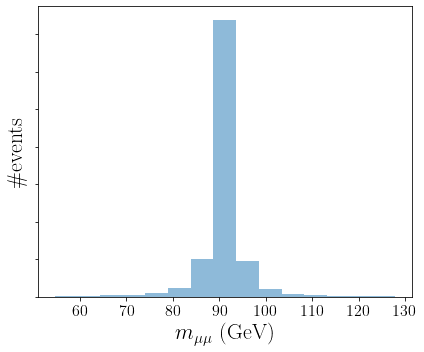

In [13]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( trn_evnt_ims, alpha=0.5, density=True, bins=15 )

axs.set_xlabel( "$m_{\mu\mu}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

fig.tight_layout()
fig.show()

Here we see the clear $Z$ mass peak at $\simeq 90$ GeV.

Now let's look at $p_T$ distributions:

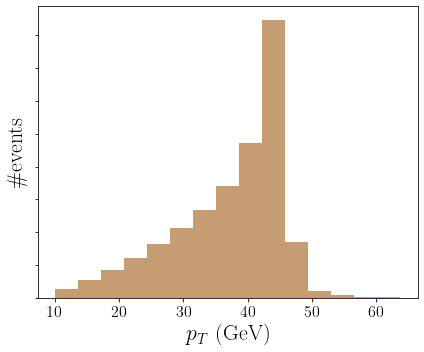

In [14]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( trn_jet1_pts, alpha=0.5, density=True, bins=15 )
axs.hist( trn_jet2_pts, alpha=0.5, density=True, bins=15 )

axs.set_xlabel( "$p_{T}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

fig.tight_layout()
fig.show()

These distributions are completely overlapping with a peak near $m_{\mu\mu}/2$.

# Datasets and dataloaders

This time we only need the dataloader to return the data, no labels, so it's pretty simple.

In [15]:
class drell_yan_data( Dataset ):
    
    def __init__( self, data ):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

Let's normalise the data a little bit by dividing all dimensionful quantities by $100$ GeV.

In [16]:
dy_trn_data_p = torch.Tensor( dy_trn_data / 100 )
dy_val_data_p = torch.Tensor( dy_val_data / 100 )
dy_tst_data_p = torch.Tensor( dy_tst_data / 100 )

In [17]:
trn_dataset = drell_yan_data( dy_trn_data_p )
val_dataset = drell_yan_data( dy_val_data_p )
tst_dataset = drell_yan_data( dy_tst_data_p )

Using a bigger batch size this time, this helps for generative networks.

In [18]:
trn_dataloader = DataLoader( trn_dataset, batch_size=2500, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=2500, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=2500, shuffle=True )

## Building the INN

In [19]:
def subnet_fc( dims_in, dims_out ):
    return nn.Sequential( nn.Linear(dims_in, 100), 
                         nn.ReLU(),
                         nn.Linear(100,  dims_out) )

In [20]:
ndim = 8
inn = Ff.SequenceINN( ndim )
for k in range(8):
    inn.append( Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True )

## Optimising the INN

First, we set the device.

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [22]:
def inn_loss( z, ndim, log_jac_det ):
    l = 0.5*torch.sum( z**2, 1 ) - log_jac_det
    l = l.mean() / ndim
    return l

In [23]:
def train_epoch( dataloader, model, optimizer ):
    
    size = len( dataloader.dataset )
    
    for batch, X in enumerate(dataloader):

        # pass data through network
        z, log_jac_det = model( X )
        
        # compute loss
        loss = inn_loss( z, ndim, log_jac_det )

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

In [24]:
def val_pass( dataloader, model ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X in dataloader:
            z, log_jac_det = model( X )
            vl += inn_loss( z, ndim, log_jac_det ).item()

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, model ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X in dataloader:
            z, log_jac_det = model( X )
            tl += inn_loss( z, ndim, log_jac_det ).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

To optimise the network we need separate optimizers for each model, and we also add a learning rate scheduler regulate the training further.

In [36]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 50

# re-initialise the model and the optimizer
def subnet_fc( dims_in, dims_out ):
    return nn.Sequential( nn.Linear(dims_in, 128), 
                         nn.ReLU(),
                         nn.Linear(128,  dims_out) )
ndim = 8
inn = Ff.SequenceINN( ndim )
for k in range(8):
    inn.append( Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True )
learning_rate = 0.001
optimizer = torch.optim.Adam( inn.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( inn )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader, inn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dataloader, inn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader, inn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
SequenceINN(
  (module_list): ModuleList(
    (0): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=8, bias=True)
      )
    )
    (1): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=8, bias=True)
      )
    )
    (2): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=8, bias=True)
      )
    )
    (3): AllInOneBlock(
      (softplus): Softp

avg val loss per batch: -2.774229
-----------------------------------------------
|
-----------------------------------------------
Epoch 11
-----------------------------------------------
current batch loss: -2.773338  [    0/1384081]
current batch loss: -2.797142  [250000/1384081]
current batch loss: -2.747659  [500000/1384081]
current batch loss: -2.753408  [750000/1384081]
current batch loss: -2.787023  [1000000/1384081]
current batch loss: -2.823620  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -2.829080
-----------------------------------------------
avg val loss per batch: -2.830124
-----------------------------------------------
|
-----------------------------------------------
Epoch 12
-----------------------------------------------
current batch loss: -2.833019  [    0/1384081]
current batch loss: -2.797567  [250000/1384081]
current batch loss: -2.842871  [500000/1384081]
current batch loss: -2.754305  [750000/1384081]
current batc

current batch loss: -3.122562  [750000/1384081]
current batch loss: -3.127491  [1000000/1384081]
current batch loss: -3.056620  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -3.145842
-----------------------------------------------
avg val loss per batch: -3.146621
-----------------------------------------------
|
-----------------------------------------------
Epoch 25
-----------------------------------------------
current batch loss: -3.152548  [    0/1384081]
current batch loss: -3.108511  [250000/1384081]
current batch loss: -3.129835  [500000/1384081]
current batch loss: -3.046397  [750000/1384081]
current batch loss: -3.128485  [1000000/1384081]
current batch loss: -3.171121  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -3.086923
-----------------------------------------------
avg val loss per batch: -3.087762
-----------------------------------------------
|
--------------------------------

current batch loss: -3.174422  [250000/1384081]
current batch loss: -3.213459  [500000/1384081]
current batch loss: -3.241357  [750000/1384081]
current batch loss: -2.868732  [1000000/1384081]
current batch loss: -2.839727  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -3.232143
-----------------------------------------------
avg val loss per batch: -3.232724
-----------------------------------------------
|
-----------------------------------------------
Epoch 39
-----------------------------------------------
current batch loss: -3.219747  [    0/1384081]
current batch loss: -3.265328  [250000/1384081]
current batch loss: -3.271748  [500000/1384081]
current batch loss: -3.211043  [750000/1384081]
current batch loss: -3.201252  [1000000/1384081]
current batch loss: -3.186126  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -3.275135
-----------------------------------------------
avg val loss per bat

## Study the results

First let's plot the training and validation losses to see how they look.

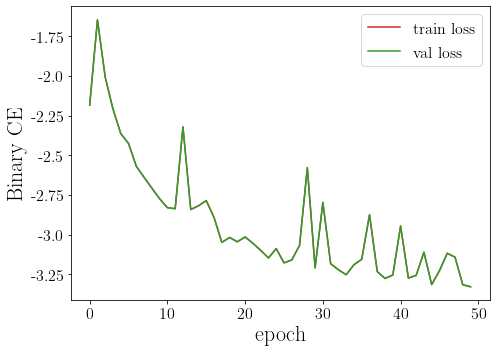

In [37]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

#axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Binary CE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

## Let's generate some events!

We first need to generate random data from the unit normal distribution, the same used during training, with the correct shape.  Here we use $10$k samples.

In [38]:
z_gen = torch.randn( (10000, ndim) )
x_gen, _ = inn( z_gen, rev=True )
x_gen = x_gen*100.0

In [39]:
x_gen.shape

torch.Size([10000, 8])

Plot the energy distribution of the first jet, for both real and generated data:

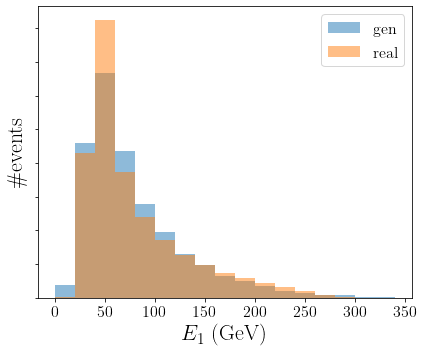

In [40]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 0, 350, step=20 )
axs.hist( x_gen.detach().numpy()[:,0], alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( dy_trn_data[:,0], alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$E_{1}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

Looks good!!

We can do the same for $p_y$ of the first jet:

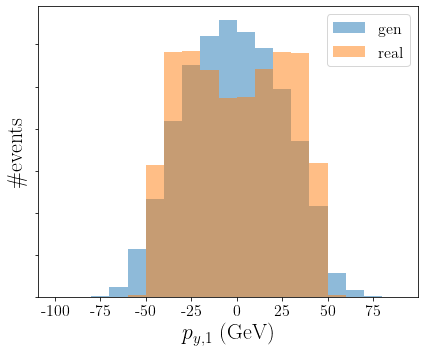

In [41]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( -100, +100, step=10 )
axs.hist( x_gen.detach().numpy()[:,2], alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( dy_trn_data[:,2], alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$p_{y,1}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

In [32]:
x_gen_evnt_ims, x_gen_evnt_pts, x_gen_jet1_pts, x_gen_jet2_pts = get_obs( x_gen.detach().numpy() )

The $p_T$ of the first jet:

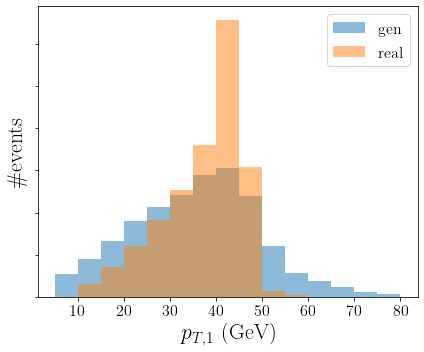

In [42]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 5, 85, step=5 )
axs.hist( x_gen_jet1_pts, alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( trn_jet1_pts, alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$p_{T,1}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

Looks good!

Now the invariant mass of the whole event:

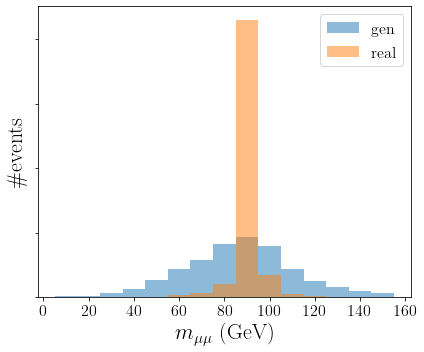

In [43]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 5, 165, step=10 )
axs.hist( np.nan_to_num( x_gen_evnt_ims ), alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( np.nan_to_num( trn_evnt_ims ), alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$m_{\mu\mu}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

## Removing redundant degrees of freedom

In the collider the incoming particles have no momentum in the $x$ or $y$ directions, therefore momentum conservation means that the final state should also not have any momentum in these directions.  This means that we have redundant degrees of freedom that can be removed from the data.

We can check this:

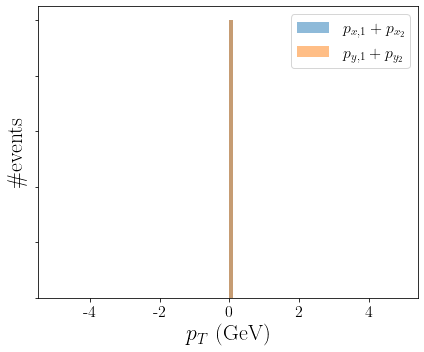

In [44]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( -5, 5, step=0.1 )
axs.hist( dy_trn_data[:,1]+dy_trn_data[:,5], alpha=0.5, density=True, bins=bins, label='$p_{x,1}+p_{x_2}$' )
axs.hist( dy_trn_data[:,2]+dy_trn_data[:,6], alpha=0.5, density=True, bins=bins, label='$p_{y,1}+p_{y_2}$' )

axs.set_xlabel( "$p_T$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

Muons have a mass of about $106$ MeV.  This is much smaller than the typical energy scales involved in the Drell-Yan process we are studying, so we can assume to a good approximation that the mass of the final state particles are zero.  These final state particles are on-shell, i.e. $p^2=m^2=0$, so we can also use this as a constraint.  We can check that this approximately holds:

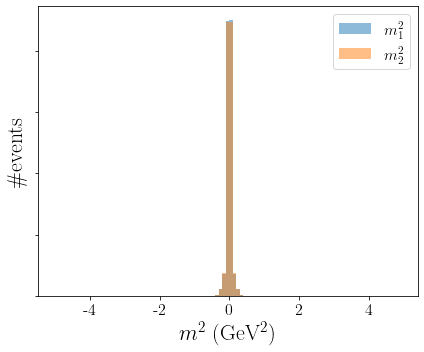

In [45]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( -5, 5, step=0.1 )
axs.hist( dy_trn_data[:,0]**2-dy_trn_data[:,1]**2-dy_trn_data[:,2]**2-dy_trn_data[:,3]**2, 
         alpha=0.5, density=True, bins=bins, label='$m_1^2$' )
axs.hist( dy_trn_data[:,4]**2-dy_trn_data[:,5]**2-dy_trn_data[:,6]**2-dy_trn_data[:,7]**2, 
         alpha=0.5, density=True, bins=bins, label='$m_2^2$' )

axs.set_xlabel( "$m^2$ (GeV$^2$)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

We can remove $p_{x,2}$, $p_{y,2}$, $E_{1}$, and $E_{2}$ by simply removing these from the data.  They can be calculated and re-introduced from:
- $p_{x,2}=-p_{x,1}$
- $p_{y,2}=-p_{y,1}$
- $E_{1}=\sqrt{p_{x,1}^2+p_{y,1}^2+p_{z,1}^2}$
- $E_{2}=\sqrt{p_{x,2}^2+p_{y,2}^2+p_{z,2}^2}=\sqrt{p_{x,1}^2+p_{y,1}^2+p_{z,2}^2}$

So we are left with $4$ degrees of freedom.

Let's re-do the data.

In [46]:
dy_trn_data_nr = np.delete( dy_trn_data, (0,1,2,4), axis=1 )
dy_val_data_nr = np.delete( dy_val_data, (0,1,2,4), axis=1 )
dy_tst_data_nr = np.delete( dy_tst_data, (0,1,2,4), axis=1 )

In [47]:
dy_trn_data_nr.shape, dy_val_data_nr.shape, dy_tst_data_nr.shape

((1384081, 4), (296588, 4), (296588, 4))

In [48]:
dy_trn_data_nr_p = torch.Tensor( dy_trn_data_nr / 100 )
dy_val_data_nr_p = torch.Tensor( dy_val_data_nr / 100 )
dy_tst_data_nr_p = torch.Tensor( dy_tst_data_nr / 100 )

In [49]:
trn_dataset_nr = drell_yan_data( dy_trn_data_nr_p )
val_dataset_nr = drell_yan_data( dy_val_data_nr_p )
tst_dataset_nr = drell_yan_data( dy_tst_data_nr_p )

In [50]:
trn_dataloader_nr = DataLoader( trn_dataset_nr, batch_size=2500, shuffle=True )
val_dataloader_nr = DataLoader( val_dataset_nr, batch_size=2500, shuffle=True )
tst_dataloader_nr = DataLoader( tst_dataset_nr, batch_size=2500, shuffle=True )

Now we need a new get_obs function:

In [51]:
def get_events_nr( event ):
    
    pz1 = event[:,0]
    px2 = event[:,1]
    py2 = event[:,2]
    pz2 = event[:,3]
    px1 = -px2
    py1 = -py2
    E1 = np.sqrt( px1**2 + py1**2 + pz1**2 )
    E2 = np.sqrt( px2**2 + py2**2 + pz2**2 )
    
    events = np.stack( ( E1,px1,py1,pz1,E2,px2,py2,pz2 ), axis=-1 )
    
    return events

def get_obs_nr( event ):
    
    pz1 = event[:,0]
    px2 = event[:,1]
    py2 = event[:,2]
    pz2 = event[:,3]
    px1 = -px2
    py1 = -py2
    E1 = np.sqrt( px1**2 + py1**2 + pz1**2 )
    E2 = np.sqrt( px2**2 + py2**2 + pz2**2 )
    
    jet1_4m = np.stack( ( E1,px1,py1,pz1 ), axis=-1 )
    jet2_4m = np.stack( ( E2,px2,py2,pz2 ), axis=-1 )
    
    evnt_4m = np.sum( (jet1_4m,jet2_4m), axis=0 )
    
    evnt_im = np.sqrt( np.sum( ( evnt_4m[:,0]**2, -evnt_4m[:,1]**2, -evnt_4m[:,2]**2, -evnt_4m[:,3]**2 ), axis=0 ) )
    
    evnt_pt = np.sqrt( evnt_4m[:,1]**2 + evnt_4m[:,2]**2 )
    jet1_pt = np.sqrt( jet1_4m[:,1]**2 + jet1_4m[:,2]**2 )
    jet2_pt = np.sqrt( jet2_4m[:,1]**2 + jet2_4m[:,2]**2 )
    
    return evnt_im, evnt_pt, jet1_pt, jet2_pt

Let's double check it:

In [52]:
trn_evnt_nr_ims, trn_evnt_nr_pts, trn_jet1_nr_pts, trn_jet2_nr_pts = get_obs_nr( dy_trn_data_nr )
val_evnt_nr_ims, val_evnt_nr_pts, val_jet1_nr_pts, val_jet2_nr_pts = get_obs_nr( dy_val_data_nr )
tst_evnt_nr_ims, tst_evnt_nr_pts, tst_jet1_nr_pts, tst_jet2_nr_pts = get_obs_nr( dy_tst_data_nr )
trn_events_nr = get_events_nr( dy_trn_data_nr )
val_events_nr = get_events_nr( dy_val_data_nr )
tst_events_nr = get_events_nr( dy_tst_data_nr )

Plot $p_{y,1}$:

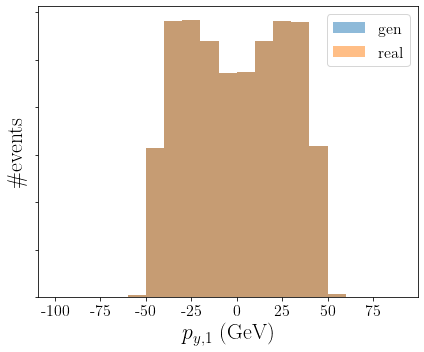

In [53]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( -100, +100, step=10 )
axs.hist( trn_events_nr[:,2], alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( dy_trn_data[:,2], alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$p_{y,1}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

Let's plot the invariant mass of the events:

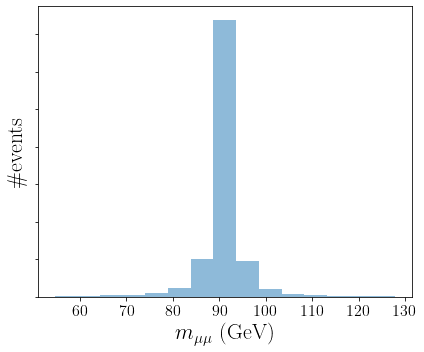

In [54]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( trn_evnt_nr_ims, alpha=0.5, density=True, bins=15 )

axs.set_xlabel( "$m_{\mu\mu}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

fig.tight_layout()
fig.show()

Here we see the clear $Z$ mass peak at $\simeq 90$ GeV.

Now let's look at $p_T$ distributions:

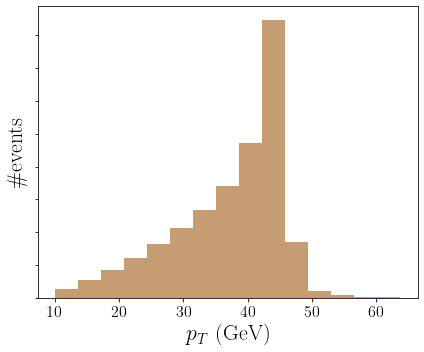

In [55]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( trn_jet1_nr_pts, alpha=0.5, density=True, bins=15 )
axs.hist( trn_jet2_nr_pts, alpha=0.5, density=True, bins=15 )

axs.set_xlabel( "$p_{T}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

fig.tight_layout()
fig.show()

So we can recover the original distributions.  Let's move on.

## Optimising the INN on the reduced data

In [59]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 50

# re-initialise the model and the optimizer
def subnet_fc( dims_in, dims_out ):
    return nn.Sequential( nn.Linear(dims_in, 128), 
                         nn.ReLU(),
                         nn.Linear(128,  dims_out) )
ndim_nr = 4
inn_nr = Ff.SequenceINN( ndim_nr )
for k in range(8):
    inn_nr.append( Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True )
learning_rate = 0.001
optimizer_nr = torch.optim.Adam( inn_nr.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( inn_nr )

# track train and val losses
trn_losses_nr = []
val_losses_nr = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader_nr, inn_nr, optimizer_nr )
    separator()
    trn_loss = trn_pass( trn_dataloader_nr, inn_nr )
    trn_losses_nr.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader_nr, inn_nr )
    val_losses_nr.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
SequenceINN(
  (module_list): ModuleList(
    (0): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=4, bias=True)
      )
    )
    (1): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=4, bias=True)
      )
    )
    (2): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=4, bias=True)
      )
    )
    (3): AllInOneBlock(
      (softplus): Softp

avg val loss per batch: -0.355529
-----------------------------------------------
|
-----------------------------------------------
Epoch 11
-----------------------------------------------
current batch loss: -0.353461  [    0/1384081]
current batch loss: -0.352750  [250000/1384081]
current batch loss: -0.360214  [500000/1384081]
current batch loss: -0.362345  [750000/1384081]
current batch loss: -0.361354  [1000000/1384081]
current batch loss: -0.350021  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -0.358748
-----------------------------------------------
avg val loss per batch: -0.358519
-----------------------------------------------
|
-----------------------------------------------
Epoch 12
-----------------------------------------------
current batch loss: -0.348066  [    0/1384081]
current batch loss: -0.357868  [250000/1384081]
current batch loss: -0.363941  [500000/1384081]
current batch loss: -0.367691  [750000/1384081]
current batc

current batch loss: -0.388538  [750000/1384081]
current batch loss: -0.376996  [1000000/1384081]
current batch loss: -0.389585  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -0.385392
-----------------------------------------------
avg val loss per batch: -0.385200
-----------------------------------------------
|
-----------------------------------------------
Epoch 25
-----------------------------------------------
current batch loss: -0.385954  [    0/1384081]
current batch loss: -0.391432  [250000/1384081]
current batch loss: -0.378470  [500000/1384081]
current batch loss: -0.393149  [750000/1384081]
current batch loss: -0.386555  [1000000/1384081]
current batch loss: -0.382388  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -0.385825
-----------------------------------------------
avg val loss per batch: -0.385633
-----------------------------------------------
|
--------------------------------

current batch loss: -0.403490  [250000/1384081]
current batch loss: -0.397028  [500000/1384081]
current batch loss: -0.399180  [750000/1384081]
current batch loss: -0.391414  [1000000/1384081]
current batch loss: -0.398318  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -0.396090
-----------------------------------------------
avg val loss per batch: -0.389952
-----------------------------------------------
|
-----------------------------------------------
Epoch 39
-----------------------------------------------
current batch loss: -0.396029  [    0/1384081]
current batch loss: -0.390531  [250000/1384081]
current batch loss: -0.394067  [500000/1384081]
current batch loss: -0.393951  [750000/1384081]
current batch loss: -0.393287  [1000000/1384081]
current batch loss: -0.399321  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -0.396799
-----------------------------------------------
avg val loss per bat

## Study the new results

We now generate data and recover the original observables.

In [61]:
z_gen_nr = torch.randn( (10000, ndim_nr) )
x_gen_nr, _ = inn_nr( z_gen_nr, rev=True )
x_gen_nr = x_gen_nr*100.0
x_gen_nr = get_events_nr( x_gen_nr.detach().numpy() )

Plot the energy distribution of the first jet, for both real and generated data:

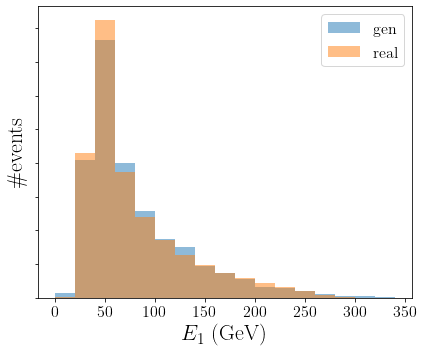

In [62]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 0, 350, step=20 )
axs.hist( x_gen_nr[:,0], alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( dy_trn_data[:,0], alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$E_{1}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

We can do the same for $p_y$ of the first jet:

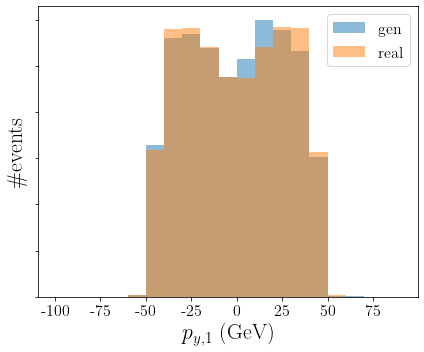

In [63]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( -100, +100, step=10 )
axs.hist( x_gen_nr[:,6], alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( dy_trn_data[:,6], alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$p_{y,1}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

Now we can look at more complicated observables which involve correlations between the different inputs.

first we need to calucate them from the generated data:

In [64]:
x_gen_evnt_nr_ims, x_gen_evnt_nr_pts, x_gen_jet1_nr_pts, x_gen_jet2_nr_pts = get_obs_nr( x_gen.detach().numpy() )

The $p_T$ of the first jet:

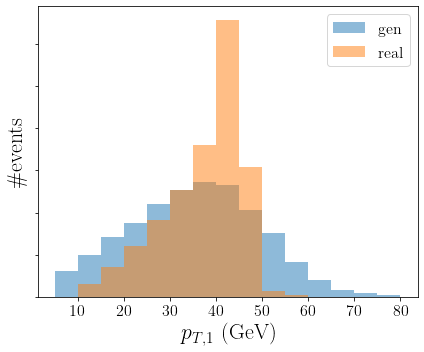

In [65]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 5, 85, step=5 )
axs.hist( x_gen_jet1_nr_pts, alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( trn_jet1_nr_pts, alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$p_{T,1}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

Looks good!

Now the invariant mass of the whole event:

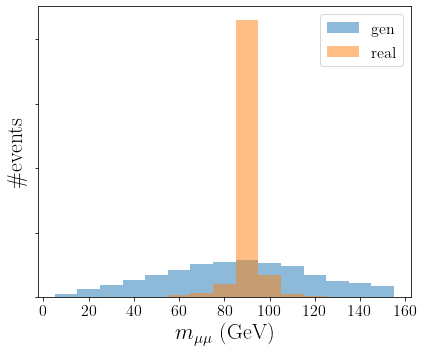

In [66]:
fig, axs = plt.subplots( figsize=(6,5) )

bins = np.arange( 5, 165, step=10 )
axs.hist( np.nan_to_num( x_gen_evnt_nr_ims ), alpha=0.5, density=True, bins=bins, label='gen' )
axs.hist( np.nan_to_num( trn_evnt_ims ), alpha=0.5, density=True, bins=bins, label='real' )

axs.set_xlabel( "$m_{\mu\mu}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()
fig.show()

Again this is not perfect, but the peak of the generated distribution is at the correct place.